In [1]:
import sys
import obspy
from obspy.imaging.beachball import beachball, beach
# from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import PIL
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dateutil import parser
from datetime import datetime, timezone

from sklearn.neighbors import KernelDensity
import seaborn as sns

#from obspy import read_inventory, read_events
import pandas as pd

from scipy import interpolate
from scipy.interpolate import interp1d

from scipy.interpolate import make_interp_spline
from scipy.integrate import * # "quad" function

%matplotlib inline

In [2]:
data = pd.read_csv('kur_eqs.csv', parse_dates=['DATE'])

In [3]:
data.columns

Index(['LON', 'LAT', 'DEPTH', 'DATE', 'TIME', 'EVENT_ID', 'DEPFIX', 'DEPQUAL',
       'EX', 'MO', 'MW', 'EX.1', 'MRR', 'MTT', 'MPP', 'MRT', 'MTP', 'MPR',
       'STRIKE', 'DIP', 'RAKE', 'STRIKE.1', 'DIP.1', 'RAKE.1', 'EX.2', 'T_VAL',
       'T_PL', 'T_AZM', 'P_VAL', 'P_PL', 'P_AZM', 'N_VAL', 'N_PL', 'N_AZM',
       'SLAB_DIP', 'CLASS', 'LON_AVE', 'LAT_AVE', 'S_AVE', 'N_AVE', 'SINSQ_T',
       'SINSQ_SS', 'SINSQ_N', 'TYPE'],
      dtype='object')

In [4]:
# data_0 = data[(data['N_AVE'] > 10)] # towards landwards
data_UP = data.loc[data['CLASS'] == 'UPPER']

data_in_slab = data[data['N_AVE'] > 0] # only in the subducting slab
data_DW = data_in_slab.loc[data['CLASS'] == 'DGOING']

data_MT = data.loc[data['CLASS'] == 'MTHRUST']

In [5]:
slab_length = pd.read_csv('kur_dep_at_prof_end_10.csv', sep = ',', header = 'infer')
slab_length=slab_length.append(slab_length, ignore_index=True)
slab_length = slab_length.sort_values(by = 'ALONG',ascending=True)
length = np.asarray(slab_length['LENGTH'])

# Upper plate

In [6]:
# data_T_UP = data_UP.loc[(data_UP['TYPE'] == 'THRUST') & (data_UP['TYPE'] == 'THRUST')]
data_T_UP = data_UP.loc[(data_UP['TYPE'] == 'THRUST') | (data_UP['TYPE'] == 'O_THRUST')]
# data_T_UP = data_UP.loc[data_UP['TYPE'] == 'O_THRUST']
data_SS_UP = data_UP.loc[data_UP['TYPE'] == 'SS']
data_N_UP = data_UP.loc[data_UP['TYPE'] == 'NORM']

In [7]:
data_df = data_T_UP.sort_values(by = 'S_AVE',ascending=True)
data_along_pos = pd.unique(data_df['S_AVE'])
data_along_energy = []

grp = data_df.groupby('S_AVE')

for pos in data_along_pos:
    to_proc = grp.get_group(pos) 
    exp = np.asarray(to_proc['EX'])
    mo = np.asarray(to_proc['MO'])
    energy = mo*np.power(10., exp)
    data_along_energy.append(np.sum(energy))
    
data_along_energy = np.asarray(data_along_energy)

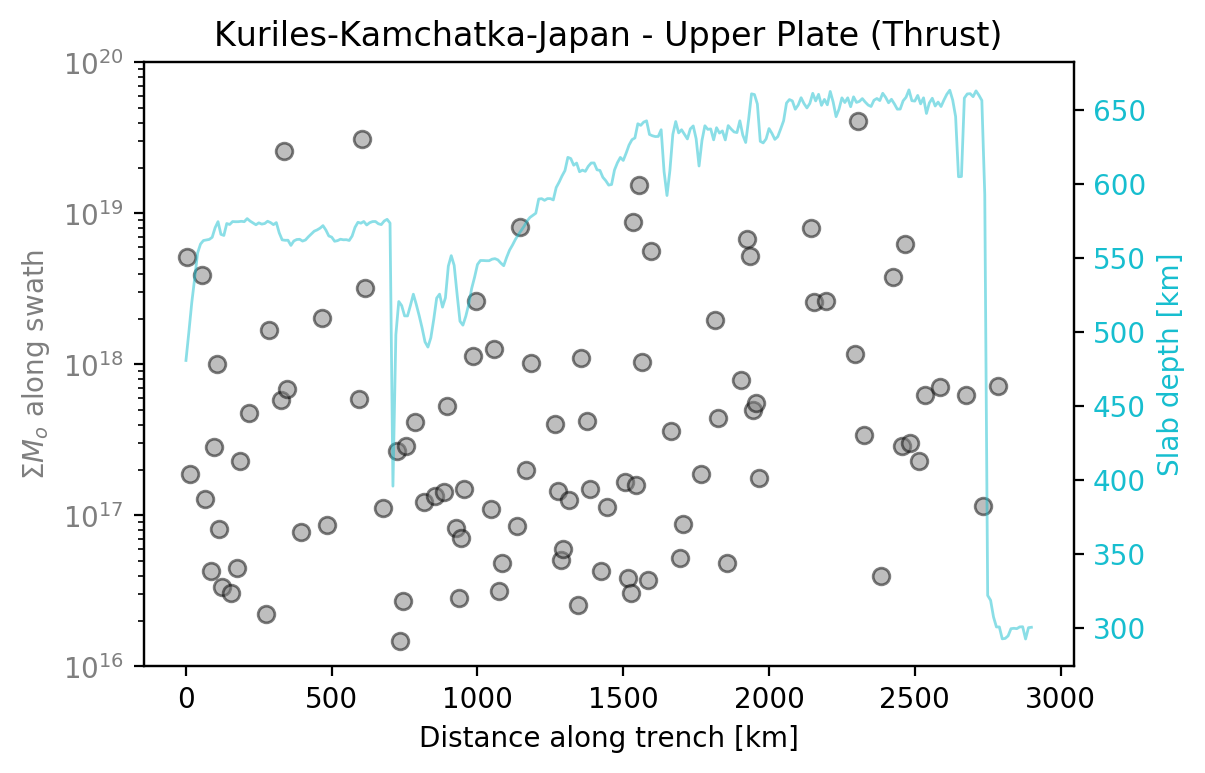

In [8]:
width = 100

fig, ax1 = plt.subplots(dpi = 200)

# plt.yscale('log')
color = 'tab:gray'
ax1.set_xlabel('Distance along trench [km]')
ax1.set_ylabel(r'$\Sigma$$M_o$ along swath', color=color)  # we already handled the x-label with ax1
# plot = ax1.bar(data_along_pos, data_along_energy, color = color, linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.5, label= 'Seismic Moment Release')
plot = ax1.scatter(data_along_pos, data_along_energy, color = color, alpha = 0.5, edgecolor = 'k')
# sns.kdeplot(data_along_energy)


# # Smoothing the curve (https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/)
# X_Y_Spline = make_interp_spline(data_along_pos, data_along_energy)
# X_ = np.linspace(data_along_pos.min(), data_along_pos.max(), 300)
# Y_ = X_Y_Spline(X_)
# plot = ax1.plot(X_, Y_, color = color, linewidth = 1)

ax1.tick_params(axis='y', labelcolor=color)

ax1.set_yscale('log')
ax1.set_ylim([1e16, 1e20])
# ax1.set_ylim([-0.5e19, 1.5e19])
# ax1.set_xlim([0, 5500])
# plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:cyan'
ax2.set_ylabel('Slab depth [km]', color=color)
ax2.plot(slab_length['ALONG'], slab_length['LENGTH']*-1, '-', color=color, alpha = 0.5, markersize = 3, linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([-30, 20])
# ax2.set_xlim([0, 5000])
# plt.title('Upper Plate Strike-Slip Earthquakes along trench (1976-2019)')
plt.title('Kuriles-Kamchatka-Japan - Upper Plate (Thrust)')
plt.savefig('KK_UP_T.png', dpi = 300)

# MegaThrust

In [9]:
data_df = data_MT.sort_values(by = 'S_AVE',ascending=True)
data_along_pos = pd.unique(data_df['S_AVE'])
data_along_energy = []

grp = data_df.groupby('S_AVE')

for pos in data_along_pos:
    to_proc = grp.get_group(pos) 
    exp = np.asarray(to_proc['EX'])
    mo = np.asarray(to_proc['MO'])
    energy = mo*np.power(10., exp)
    data_along_energy.append(np.sum(energy))
    
data_along_energy = np.asarray(data_along_energy)

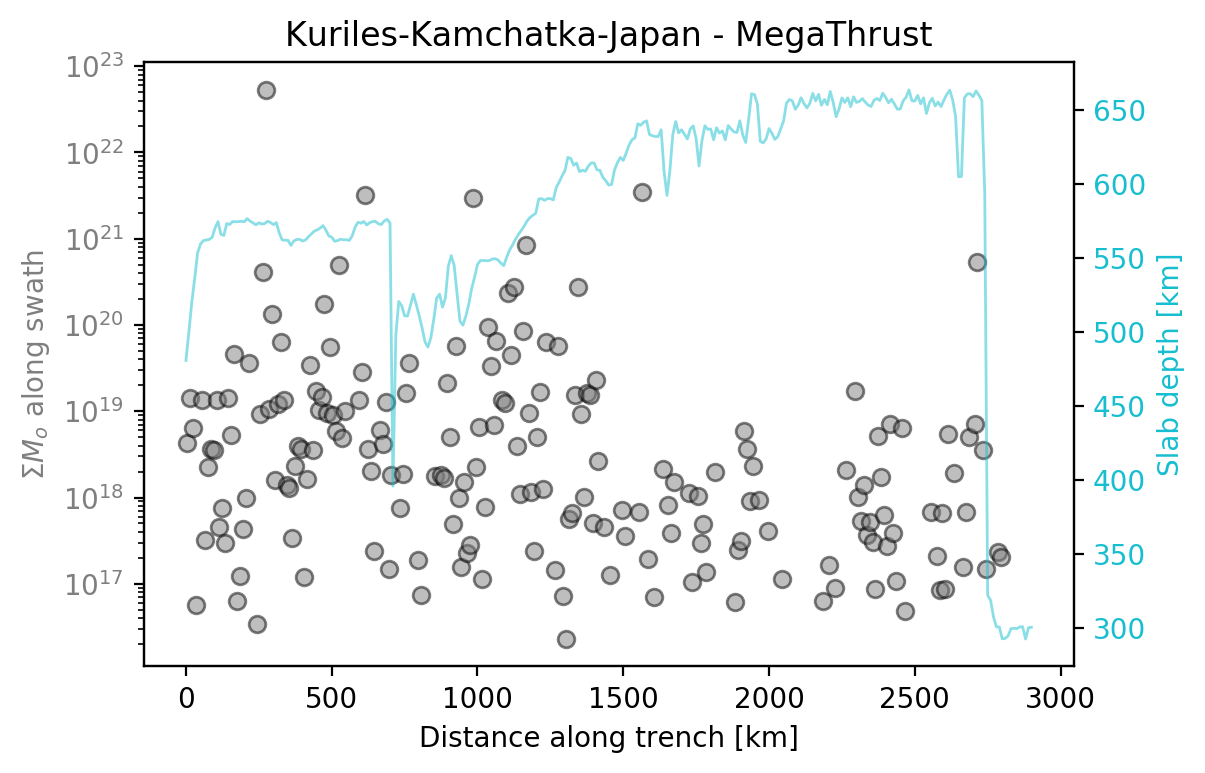

In [10]:
width = 100

fig, ax1 = plt.subplots(dpi = 200)

# plt.yscale('log')
color = 'tab:gray'
ax1.set_xlabel('Distance along trench [km]')
ax1.set_ylabel(r'$\Sigma$$M_o$ along swath', color=color)  # we already handled the x-label with ax1
# plot = ax1.bar(data_along_pos, data_along_energy, color = color, linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.5, label= 'Seismic Moment Release')
plot = ax1.scatter(data_along_pos, data_along_energy, color = color, alpha = 0.5, edgecolor = 'k')
# sns.kdeplot(data_along_energy)


# # Smoothing the curve (https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/)
# X_Y_Spline = make_interp_spline(data_along_pos, data_along_energy)
# X_ = np.linspace(data_along_pos.min(), data_along_pos.max(), 300)
# Y_ = X_Y_Spline(X_)
# plot = ax1.plot(X_, Y_, color = color, linewidth = 1)

ax1.tick_params(axis='y', labelcolor=color)

ax1.set_yscale('log')
# ax1.set_ylim([1e16, 1e23])
# ax1.set_ylim([-0.5e19, 1.5e19])
# ax1.set_xlim([0, 5500])
# plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:cyan'
ax2.set_ylabel('Slab depth [km]', color=color)
ax2.plot(slab_length['ALONG'], slab_length['LENGTH']*-1, '-', color=color, alpha = 0.5, markersize = 3, linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([-30, 20])
# ax2.set_xlim([0, 5000])
# plt.title('Upper Plate Strike-Slip Earthquakes along trench (1976-2019)')
plt.title('Kuriles-Kamchatka-Japan - MegaThrust')
plt.savefig('KK_Megathrust.png', dpi = 300)

# DownGoing

In [11]:
data_df = data_DW.sort_values(by = 'S_AVE',ascending=True)
data_along_pos = pd.unique(data_df['S_AVE'])
data_along_energy = []

grp = data_df.groupby('S_AVE')

for pos in data_along_pos:
    to_proc = grp.get_group(pos) 
    exp = np.asarray(to_proc['EX'])
    mo = np.asarray(to_proc['MO'])
    energy = mo*np.power(10., exp)
    data_along_energy.append(np.sum(energy))
    
data_along_energy = np.asarray(data_along_energy)

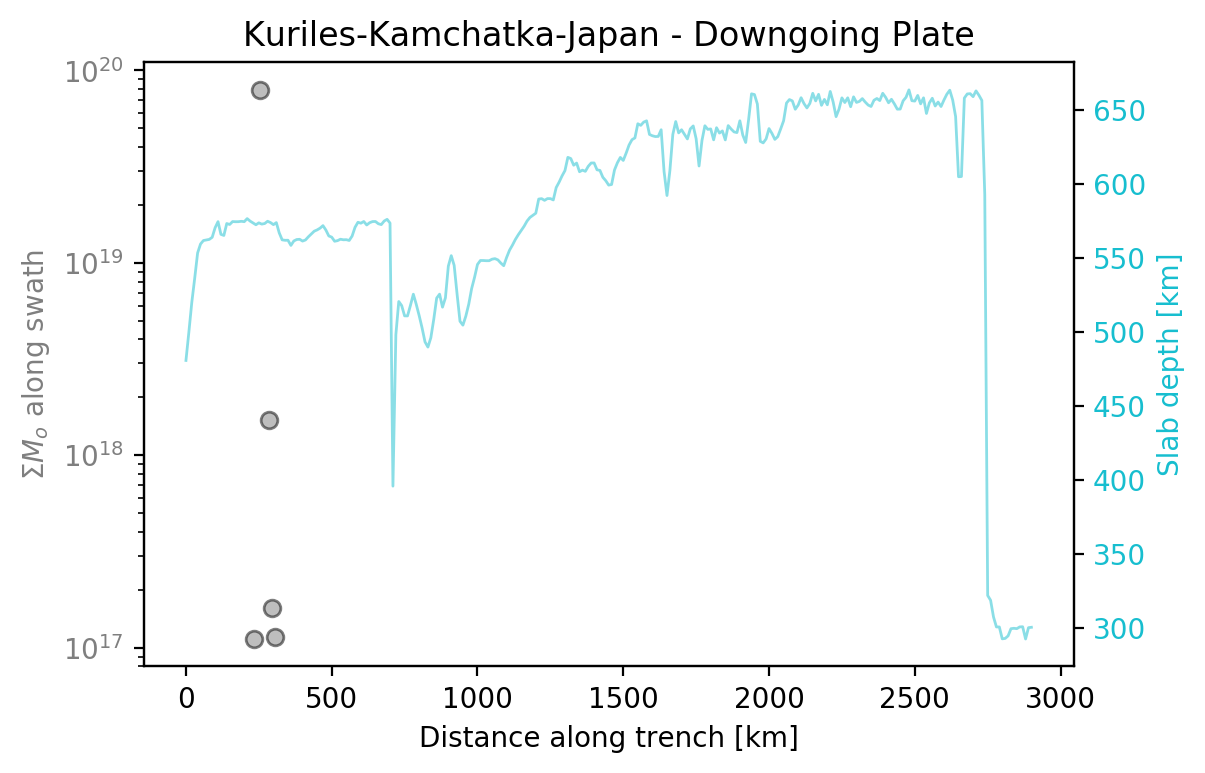

In [12]:
width = 100

fig, ax1 = plt.subplots(dpi = 200)

# plt.yscale('log')
color = 'tab:gray'
ax1.set_xlabel('Distance along trench [km]')
ax1.set_ylabel(r'$\Sigma$$M_o$ along swath', color=color)  # we already handled the x-label with ax1
# plot = ax1.bar(data_along_pos, data_along_energy, color = color, linewidth = 0.5, edgecolor = 'k', width = width, alpha = 0.5, label= 'Seismic Moment Release')
plot = ax1.scatter(data_along_pos, data_along_energy, color = color, alpha = 0.5, edgecolor = 'k')
# sns.kdeplot(data_along_energy)


# # Smoothing the curve (https://www.geeksforgeeks.org/how-to-plot-a-smooth-curve-in-matplotlib/)
# X_Y_Spline = make_interp_spline(data_along_pos, data_along_energy)
# X_ = np.linspace(data_along_pos.min(), data_along_pos.max(), 300)
# Y_ = X_Y_Spline(X_)
# plot = ax1.plot(X_, Y_, color = color, linewidth = 1)

ax1.tick_params(axis='y', labelcolor=color)

ax1.set_yscale('log')
# ax1.set_ylim([1e16, 1e23])
# ax1.set_ylim([-0.5e19, 1.5e19])
# ax1.set_xlim([0, 5500])
# plt.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:cyan'
ax2.set_ylabel('Slab depth [km]', color=color)
ax2.plot(slab_length['ALONG'], slab_length['LENGTH']*-1, '-', color=color, alpha = 0.5, markersize = 3, linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([-30, 20])
# ax2.set_xlim([0, 5000])
# plt.title('Upper Plate Strike-Slip Earthquakes along trench (1976-2019)')
plt.title('Kuriles-Kamchatka-Japan - Downgoing Plate')
plt.savefig('KK_DW.png', dpi = 300)